## **Calculating Statistics for Regional Sub-Domains**

### **Description:**

This recipe shows how to calculate statistics for regional sub-domains using monthly-mean outputs from the National Oceanography Centre Near-Present-Day global eORCA1 configuration of NEMO forced using JRA55-do from 1976-2024.

For more details on this model configuration and the available outputs, users can explore the Near-Present-Day documentation [here](https://noc-msm.github.io/NOC_Near_Present_Day/).

---

In [1]:
# -- Import required packages -- #
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from nemo_cookbook import NEMODataTree

xr.set_options(display_style="text")

### **Using Dask**

**Optional: Connect Client to Dask Local Cluster to run analysis in parallel.**

Note that, although using Dask is not strictly necessary for this simple example using eORCA1, if we wanted to generalise this recipe to eORCA025 or eORCA12 outputs, using Dask would be essential to avoid unnecessary slow calculations using only a single process.

In [ ]:
# -- Initialise Dask Local Cluster -- #
import os
import dask
from dask.distributed import Client, LocalCluster

# Update temporary directory for Dask workers:
dask.config.set({'temporary_directory': f"{os.getcwd()}/dask_tmp",
                 'local_directory': f"{os.getcwd()}/dask_tmp"
                 })

# Create Local Cluster:
cluster = LocalCluster(n_workers=4, threads_per_worker=3, memory_limit='5GB')
client = Client(cluster)
client

### **Accessing NEMO Model Data**
**Let's begin by loading the grid variables for our eORCA1 JRA-55 model from the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/)**. 

**Alternatively, you can replace the ``domain_filepath`` below with a file path to your domain_cfg.nc file and read this with xarray's ``open_dataset()`` function.**

In [2]:
# Define directory path to ancillary files:
domain_filepath = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/domain/domain_cfg"

# Open eORCA1 NEMO model domain_cfg:
ds_domain = xr.open_zarr(domain_filepath, consolidated=True, chunks={})

ds_domain

<xarray.Dataset> Size: 667MB
Dimensions:        (t: 1, y: 331, x: 360, z: 75)
Dimensions without coordinates: t, y, x, z
Data variables: (12/54)
    e1t            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e2v            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    bottom_level   (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e2t            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e2u            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    bathy_metry    (t, y, x) float32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    ...             ...
    nav_lev        (z) float32 300B dask.array<chunksize=(75,), meta=np.ndarray>
    mask_csundef   (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    nav_lat        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_counter   (t) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    top_level      (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
Attributes:
    DOMAIN_number_total:     1
    DOMAIN_number:           0
    DOMAIN_dimensions_ids:   [1, 2]
    DOMAIN_size_global:      [362, 332]
    DOMAIN_size_local:       [362, 332]
    DOMAIN_position_first:   [1, 1]
    DOMAIN_position_last:    [362, 332]
    DOMAIN_halo_size_start:  [0, 0]
    DOMAIN_halo_size_end:    [0, 0]
    DOMAIN_type:             BOX
    history:                 Mon Jun  5 12:41:32 2023: ncks -A mask.nc ORCA1_...
    NCO:                     4.4.7

**Next, we will import the sea surface temperature and sea surface salinity stored at T-points in a single dataset.**

**Typically, NEMO model outputs defined on T-grid points are stored together in netCDF files. In this case, you can replace `xr.merge()` with a single call to xarray's `open_dataset()` function passing the file path to your `_gridT.nc` file(s).**

In [3]:
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/T1m"

# Construct NEMO model grid dataset, including vertical grid cell thicknesses (m) and meridional velocities (m/s):
ds_gridT = xr.merge([xr.open_zarr(f"{output_dir}/{var}", consolidated=True, chunks={})[var] for var in ['tos_con', 'sos_abs']], compat="override")

ds_gridT

<xarray.Dataset> Size: 552MB
Dimensions:        (y: 331, x: 360, time_counter: 577)
Coordinates:
    nav_lat        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 5kB 1976-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x
Data variables:
    tos_con        (time_counter, y, x) float32 275MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    sos_abs        (time_counter, y, x) float32 275MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
Attributes:
    cell_methods:        time: mean (interval: 3600 s)
    interval_operation:  3600 s
    interval_write:      1 month
    long_name:           sea_surface_conservative_temperature
    online_operation:    average
    standard_name:       sea_surface_temperature
    units:               degC

### **Creating a NEMODataTree**

**Next, let's create a NEMODataTree to store our domain and V-grid variables for the eORCA1 model.**

In [4]:
# Define dictionary of grid datasets defining eORCA1 parent model domain with no child/grand-child nests:
# Note: domain_cfg z-dimension is expected to be named 'nav_lev'.
datasets = {"parent": {"domain": ds_domain.rename({"z": "nav_lev"}), "gridT": ds_gridT}}

# Initialise a new NEMODataTree whose parent domain is zonally periodic & north-folding on F-points:
nemo = NEMODataTree.from_datasets(datasets=datasets, iperio=True, nftype="F")

nemo

<xarray.DataTree>
Group: /
│   Dimensions:        (time_counter: 577)
│   Coordinates:
│       time_centered  (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
│     * time_counter   (time_counter) datetime64[ns] 5kB 1976-01-16T12:00:00 ... ...
│   Attributes:
│       nftype:   F
│       iperio:   True
├── Group: /gridT
│       Dimensions:        (time_counter: 577, j: 331, i: 360, k: 75)
│       Coordinates:
│           time_centered  (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
│           gphit          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamt          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j              (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i              (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│       Data variables:
│           tos_con        (time_counter, j, i) float32 275MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           sos_abs        (time_counter, j, i) float32 275MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           e1t            (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2t            (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           top_level      (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           bottom_level   (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           tmask          (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridU
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphiu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j             (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i             (i) float64 3kB 1.5 2.5 3.5 4.5 ... 357.5 358.5 359.5 360.5
│       Data variables:
│           e1u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           umask         (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridV
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphiv         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamv         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j             (j) float64 3kB 1.5 2.5 3.5 4.5 ... 328.5 329.5 330.5 331.5
│         * i             (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│       Data variables:
│           e1v           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2v           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           vmask         (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridW
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphit         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamt         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) float64 600B 0.5 1.5 2.5 3.5 4.5 ... 71.5 72

### **Defining a Regional Sub-Domain using a Bounding Box**

**Now we have constructed our `NEMODataTree`, let's start by defining a regional sub-domain using a geographical bounding box.**


**By using the `clip_grid()` method, we permanently modify the size of the specfied grid stored in our NEMODataTree.**

**Alternatively, we can use `clip_domain()` to clip all of the grids associated with a given NEMO model domain to a given bounding box.**

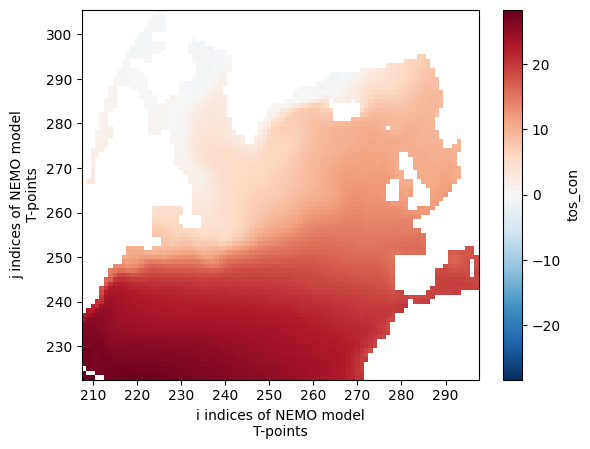

In [5]:
# Define bounding box (lon_min, lon_max, lat_min, lat_max)
bbox = (-80, 10, 20, 70)

# Clip eORCA1 model T-grid to bounding box:
nemo.clip_grid(grid='/gridT', bbox=bbox)

# Plotting time-mean sea surface temperature for the regional sub-domain:
nemo['/gridT']['tos_con'].mean(dim='time_counter').plot()

In [6]:
nemo

<xarray.DataTree>
Group: /
│   Dimensions:        (time_counter: 577)
│   Coordinates:
│       time_centered  (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
│     * time_counter   (time_counter) datetime64[ns] 5kB 1976-01-16T12:00:00 ... ...
│   Attributes:
│       nftype:   F
│       iperio:   True
├── Group: /gridT
│       Dimensions:        (time_counter: 577, j: 83, i: 90, k: 75)
│       Coordinates:
│           time_centered  (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
│           gphit          (j, i) float64 60kB 20.54 20.54 20.55 ... 71.4 71.07 70.74
│           glamt          (j, i) float64 60kB -79.5 -78.5 -77.5 ... 30.06 31.15 32.2
│         * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j              (j) int64 664B 223 224 225 226 227 ... 301 302 303 304 305
│         * i              (i) int64 720B 208 209 210 211 212 ... 293 294 295 296 297
│       Data variables:
│           tos_con        (time_counter, j, i) float32 17MB dask.array<chunksize=(1, 83, 90), meta=np.ndarray>
│           sos_abs        (time_counter, j, i) float32 17MB dask.array<chunksize=(1, 83, 90), meta=np.ndarray>
│           e1t            (j, i) float64 60kB dask.array<chunksize=(83, 90), meta=np.ndarray>
│           e2t            (j, i) float64 60kB dask.array<chunksize=(83, 90), meta=np.ndarray>
│           top_level      (j, i) int32 30kB dask.array<chunksize=(83, 90), meta=np.ndarray>
│           bottom_level   (j, i) int32 30kB dask.array<chunksize=(83, 90), meta=np.ndarray>
│           tmask          (k, j, i) bool 560kB True True True ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   False
├── Group: /gridU
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphiu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j             (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i             (i) float64 3kB 1.5 2.5 3.5 4.5 ... 357.5 358.5 359.5 360.5
│       Data variables:
│           e1u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           umask         (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridV
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphiv         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamv         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j             (j) float64 3kB 1.5 2.5 3.5 4.5 ... 328.5 329.5 330.5 331.5
│         * i             (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│       Data variables:
│           e1v           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2v           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           vmask         (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridW
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphit         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamt         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) float64 600B 0.5 1.5 2.5 3.5 4.5 ... 71.5 72.5 73.5 74.5
│         * j             (j) int64 3

### **Defining a Regional Sub-Domain using a Polygon**

**Next, let's define a more complex regional sub-domain by constructing a mask using a polygon. Since we have already clipped the T-grid of our NEMODataTree parent domain, we will define a polygon comprised of longitude-latitude coordinates within this region.**

**We will use the Overturning in the Subpolar North Atlantic Program (OSNAP) observational array coordinates made available via the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/) to construct a polygon enclosing the North Atlantic subpolar gyre**.

In [7]:
# Open OSNAP gridded observations dataset: 
ds_osnap = xr.open_zarr("https://noc-msm-o.s3-ext.jc.rl.ac.uk/ocean-obs/OSNAP/OSNAP_Gridded_TSV_201408_202006_2023")

# Define a closed polygon which includes both the OSNAP West & East arrays:
lon_poly = np.concatenate([ds_osnap['LONGITUDE'].values, np.array([ds_osnap['LONGITUDE'][-1], ds_osnap['LONGITUDE'][0]])])
lat_poly = np.concatenate([ds_osnap['LATITUDE'].values, np.array([ds_osnap['LATITUDE'][0], ds_osnap['LATITUDE'][0]])])

**Now we have defined our polygon, we can use the `mask_with_polygon()` method to return the boolean mask classifying whether NEMO model grid points are inside (True) or outside (False) the polygon**

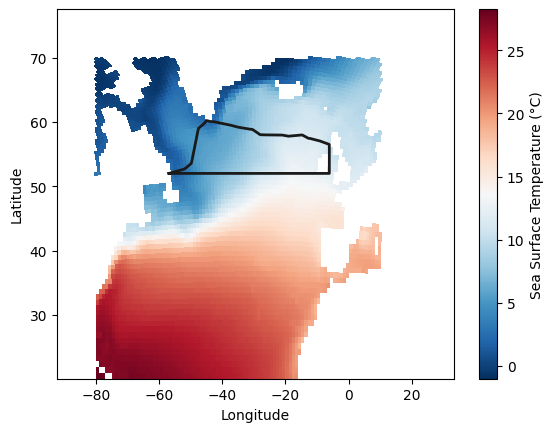

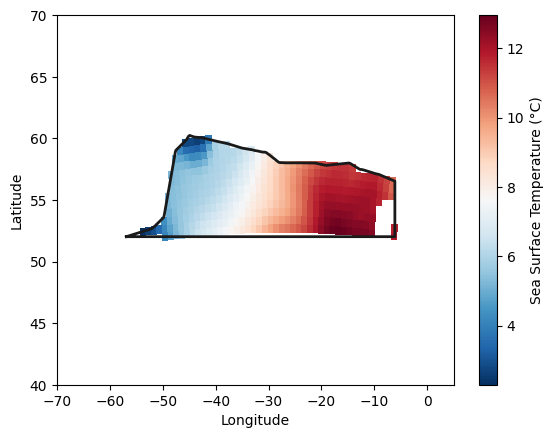

In [8]:
# Masking T-grid using polygon coordinates:
mask_spg = nemo.mask_with_polygon(grid='/gridT', lon_poly=lon_poly, lat_poly=lat_poly)

# Plotting SPG polygon sub-domain:
plt.figure()
plt.pcolormesh(nemo['/gridT']['glamt'], nemo['/gridT']['gphit'], nemo['/gridT']['tos_con'].mean(dim='time_counter'), cmap='RdBu_r')
plt.plot(lon_poly, lat_poly, color='0.1', lw=2)
plt.colorbar(label='Sea Surface Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plotting time-mean sea surface temperature for the SPG polygon sub-domain:
plt.figure()
plt.pcolormesh(nemo['/gridT']['glamt'], nemo['/gridT']['gphit'], nemo['/gridT']['tos_con'].mean(dim='time_counter').where(mask_spg), cmap='RdBu_r')
plt.plot(lon_poly, lat_poly, color='0.1', lw=2)
plt.colorbar(label='Sea Surface Temperature (°C)')
plt.xlabel('Longitude')
plt.xlim([-70, 5])
plt.ylabel('Latitude')
plt.ylim([40, 70])
plt.show()

### **Calculating statistics for a Regional Sub-Domain**

**Finally, let's use our North Atlantic subpolar gyre polygon to calculate statistics for this regional sub-domain of the eORCA1 model.**

**Given a closed polygon, we can use the `masked_statistic()` method to calculate statistics of a specified variable in the masked sub-domain**

Text(0, 0.5, 'Sea Surface Temperature (°C)')

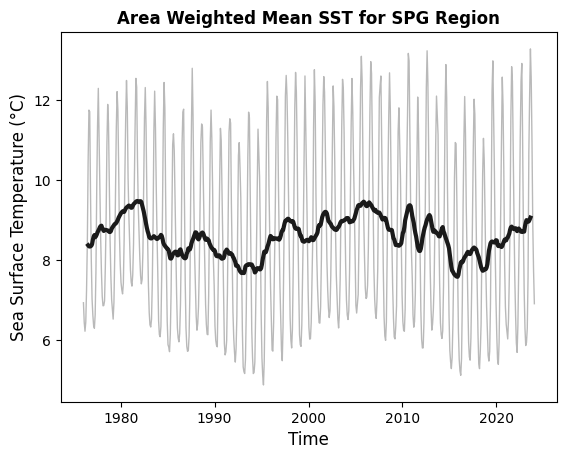

In [9]:
# Calculating the area weighted-mean sea surface temperature in the SPG region:
sst_wmean = nemo.masked_statistic(grid="/gridT",
                                  var="tos_con",
                                  lon_poly=lon_poly,
                                  lat_poly=lat_poly,
                                  statistic="weighted_mean",
                                  dims=["i", "j"]
                                  )

sst_wmean.plot(lw=1, color='0.1', alpha=0.3)
sst_wmean.rolling(time_counter=12, center=True).mean().plot(lw=3, color='0.1')
plt.title('Area Weighted Mean SST for SPG Region', fontsize=12, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sea Surface Temperature (°C)', fontsize=12)